# <font color='orange'>LONG-FORMER:The Long Document Transformer</font>

## WHY NOT BERT or Other BERT BASED MODELS

[HUGGING FACE SAYS](https://huggingface.co/transformers/model_doc/longformer.html)
> Transformer-based models are unable to process long sequences due to their <font color='red'>self-attention</font> operation, which scales quadratically with the sequence length. To address this limitation, we introduce the <font color='orange'>Longformer</font> with an attention mechanism that scales linearly with sequence length, making it easy to process documents of thousands of tokens or longer. Longformer’s attention mechanism is a drop-in replacement for the standard self-attention and combines a local windowed attention with a task motivated global attention.
> 
In simple words there is <font color='red'>limitation of 512 tokens</font> input for BERT,Roberta,Distillbert or Albert.
BUT 
There is no such cap in LONG-FORMER

## Necessary Imports


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# visualisation
import seaborn as sns


#Transformer
import torch
from transformers import LongformerModel, LongformerTokenizer


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


/kaggle/input/news_articles.csv


# <font color='orange'>OUR TASK</font>
We have used Long-Former for creating Content Embeddings which will be used In Clustering.
And further those clusters are used to Handle
1. <font color='red'>User-cold start</font> problem = This is the situation when any new user enters into our news recommendation platform
2. <font color='red'>Item-cold start</font>  problem = This is the situation when any new item( in our case news articles) enters into our platform.

We have explained our approach clearly in our report

In [2]:
news=pd.read_csv('/kaggle/input/news_articles.csv')# reading the file

### Some Very Important Refrences
1. [Hugging Face Implementation](https://huggingface.co/transformers/model_doc/longformer.html)
2. [Original Paper](https://arxiv.org/pdf/2004.05150.pdf?forcedefault=true)
3. [Blog By Chris Mccormick](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/)
4. [Jay Alammar](https://jalammar.github.io/illustrated-bert/)

### Some Data Inspection :)

In [3]:
print(news.columns)
print('\n')
print(news.dtypes)
news.head()

Index(['Article_Id', 'Title', 'Author', 'Date', 'Content', 'URL'], dtype='object')


Article_Id     int64
Title         object
Author        object
Date          object
Content       object
URL           object
dtype: object


,Article_Id,Title,Author,Date,Content,URL
0,0,14 dead after bus falls into canal in Telangan...,Devyani Sultania,"August 22, 2016 12:34 IST",At least 14 people died and 17 others were inj...,http://www.ibtimes.co.in/14-dead-after-bus-fal...
1,1,Pratibha Tiwari molested on busy road Saath ...,Suparno Sarkar,"August 22, 2016 19:47 IST",TV actress Pratibha Tiwari who is best known ...,NaN
2,2,US South Korea begin joint military drill ami...,Namrata Tripathi,"August 22, 2016 18:10 IST",The United States and South Korea began a join...,http://www.ibtimes.co.in/us-south-korea-begin-...
3,3,Illegal construction in Bengaluru Will my hou...,S V Krishnamachari,"August 22, 2016 17:39 IST",The relentless drive by Bengaluru s Bangalore...,http://www.ibtimes.co.in/illegal-construction-...
4,4,Punjab Gau Rakshak Dal chief held for assaulti...,Pranshu Rathee,"August 22, 2016 17:34 IST",Punjab Gau Raksha Dal chief Satish Kumar and h...,http://www.ibtimes.co.in/punjab-gau-rakshak-da...


In [4]:
news['len_content']=news['Content'].apply(lambda x : len(x))

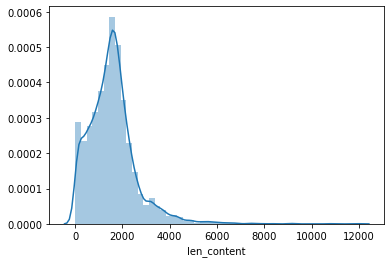

In [5]:
sns.distplot(news['len_content'])

## Very Important Point
> Above Plot clearly shows if we had used BERT or some other models we would have lot of information loss because most of our content lies above length 500

# <font color='purple'>Hugging Face</font> comes to Rescue
![](https://telegra.ph/file/f06787c5d492d528d342c.jpg)

In [6]:
model = LongformerModel.from_pretrained('allenai/longformer-base-4096',output_hidden_states = True)
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()


LongformerModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(4098, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): LongformerSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (query_global): Linear(in_features=768, out_features=768, bias=True)
            (key_global): Linear(in_features=768, out_features=768, bias=True)
            (value_global): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): BertSelfOutpu

### Refrencing The Jay Alammar
He said to get Best Contextualised word  embeddings from these Attention Based Models 
We Will Sum the Outputs of <font color='blue'>Last 4 Hidden layers</font> of BERT model.

![](http://jalammar.github.io/images/bert-feature-extraction-contextualized-embeddings.png)

This point lead me to the conclusion if we can get Best Word Embeddings from last 4 layers
So Our Whole content is basically Summation of Words So we will get Best Content Embeddings
If we <font color='red'>Element Wise Sum Word Embeddings of Each word</font> in the Content.

### SOME MORE THEORY  :-)
![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR3I2YkJ3IOBvwdZsPuBXUJQaajl2X9oGMaxO1SGh1V3DXBbdNP&usqp=CAU)

# Before Diving Into Code


## Now what is  2?
Long-former supports the concept of both local and Global attention
And  to give any token Local attention assign it value **1**
To give any token Global  Attention assign it value **2**
and 
Even if we do not want to give any attention assign it value **0**

##  <font color='purple'>HUGGING FACE</font> SAYS

> Longformer self attention employs self attention on both a “local” context and a “global” context. Most tokens only attend “locally” to each other meaning that each token attends to its 12w previous tokens and 12w succeding tokens with w being the window length as defined in config.attention_window. Note that config.attention_window can be of type list to define a different w for each layer. A selecetd few tokens attend “globally” to all other tokens, as it is conventionally done for all tokens in e.g. BertSelfAttention.
> 
> Note that “locally” and “globally” attending tokens are projected by different query, key and value matrices. Also note that every “locally” attending token not only attends to tokens within its window w, but also to all “globally” attending tokens so that global attention is symmetric.
> 
> The user can define which tokens attend “locally” and which tokens attend “globally” by setting the tensor global_attention_mask at run-time appropriately. Longformer employs the following logic for global_attention_mask: 0 - the token attends “locally”, 1 - token attends “globally”. For more information please also refer to forward() method.
> 
> Using Longformer self attention, the memory and time complexity of the query-key matmul operation, which usually represents the memory and time bottleneck, can be reduced from O(ns×ns) to O(ns×w), with ns being the sequence length and w being the average window size. It is assumed that the number of “globally” attending tokens is insignificant as compared to the number of “locally” attending tokens.

## One Question you might face?

### What are sequence and pooled outputs?

Answer is [here](https://www.kaggle.com/questions-and-answers/86510)

## Summing the results from last 4 layers of Model
## to get word embedding

For quick execution I have created emeddings just for first 5 articles

To get embeddings replace first line of below cell

> all_content=list(news['Content'][:])

In [7]:
all_content=list(news['Content'][:5])
#doing only for first 5 contents
# because doing for complete takes 2 hours on CPU

def sentence_bert():
    list_of_emb=[]
    for i in range(len(all_content)):
        SAMPLE_TEXT = all_content[i]  # long input document
        input_ids = torch.tensor(tokenizer.encode(SAMPLE_TEXT)).unsqueeze(0)  # batch of size 1

        # Attention mask values -- 0: no attention, 1: local attention, 2: global attention
        attention_mask = torch.ones(input_ids.shape, dtype=torch.long, device=input_ids.device) # initialize to local attention
        attention_mask[:, [0,-1]] = 2  # Set global attention based on the task. For example,
                                            # classification: the <s> token
                                            # QA: question tokens
                                            # LM: potentially on the beginning of sentences and paragraphs

        # we have set <s> and </s> token's attention mask =2
        # because acc to Longformer documentation these tokens must be given 
        # global attention when we are doing sentence classification
        # Run the text through BERT, and collect all of the hidden states produced


        # from all 12 layers. 
        with torch.no_grad():

            outputs = model(input_ids, attention_mask=attention_mask)

            # Evaluating the model will return a different number of objects based on 
            # how it's  configured in the `from_pretrained` call earlier. In this case, 
            # becase we set `output_hidden_states = True`, the third item will be the 
            # hidden states from all layers. See the documentation for more details:
            # https://huggingface.co/transformers/
            hidden_states = outputs[2]
            
            #outputs[0] gives us sequence_output
            #outputs[1] gives us pooled_output
            #outputs[2] gives us Hidden_output
            


        # Concatenate the tensors for all layers. We use `stack` here to
        # create a new dimension in the tensor.
        token_embeddings = torch.stack(hidden_states, dim=0)

        # Remove dimension 1, the "batches".
        token_embeddings = torch.squeeze(token_embeddings, dim=1)
        # Swap dimensions 0 and 1.
        token_embeddings = token_embeddings.permute(1,0,2)


        token_vecs_sum = []



        # For each token in the sentence...
        for token in token_embeddings:

            


            #but preferrable is
            sum_vec=torch.sum(token[-4:],dim=0)

            # Use `sum_vec` to represent `token`.
            token_vecs_sum.append(sum_vec)

#         print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

        h=0
        for i in  range(len(token_vecs_sum)):
            h+=token_vecs_sum[i]
            
            
        list_of_emb.append(h)
    return list_of_emb
f=sentence_bert()
print(len(f))
    

5


In [8]:
f[0].shape  #  embedding  for first sentence

torch.Size([768])

### Saving the Embeddings

In [9]:
import pickle
with open("/kaggle/working/emeddings_bert_mean.txt", "wb") as fp:
    pickle.dump(f, fp)

/opt/conda/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


<font color='red'> If you liked my work and teams work pls  consider an  upvote</font>